# Filter Delta2 Data Pseudomonas aeruginosa
 
In this notebook we filter the time-lapse data of Pseudomonas aeruginosa mutant strains with cdg sensor growing on agar-pads

filtering is done using the custom filter_paired_tracks function provided in filter_paired_tracks.py file.

---

## Import packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns
import pathlib

from filter_paired_tracks import filter_paired_tracks

---

## Setup Folders

In [2]:
root = pathlib.Path(pathlib.Path.home(), 'switchdrive', 'Biozentrum', 'Andreas')
csv_dir = root / 'data_files_individual_colonies' / 'csv_files_Pa'

image_dir = pathlib.Path.cwd() / 'images'
save_dir = pathlib.Path.cwd() / 'data_files'

---

## Load Data
We load the data files of the individual colonies and merge them together.

In [3]:
file_list = [pd.read_csv(csv_dir/f.name) for f in sorted(csv_dir.glob('*.csv'))]
df = pd.concat(file_list, ignore_index=True).reset_index()

We add a unique ID for each cell pair (two cells with shared parent) by combining strain id, replicate id, and par id

In [4]:
#add unique id of cell by combining strain and replicate
df['uni_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_cell'].map(str)
df['uni_par_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_par'].map(str)
df.head()


,index,Unnamed: 0,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,...,fluo3,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,uni_par_id
0,0,0,0,0,-1,0,-1,-1,-1,0,...,1283.958678,397.797521,462.024793,0.0,0,10_pilH,10_pilH_TL_01_17_s2,0,10_pilH-0-0,10_pilH-0--1
1,1,1,0,0,-1,0,-1,-1,-1,1,...,1260.195918,397.287755,462.959184,0.0,1,10_pilH,10_pilH_TL_01_17_s2,0,10_pilH-0-0,10_pilH-0--1
2,2,2,0,0,-1,0,-1,-1,-1,2,...,1240.088583,397.527559,462.872047,0.0,2,10_pilH,10_pilH_TL_01_17_s2,0,10_pilH-0-0,10_pilH-0--1
3,3,3,0,0,-1,0,-1,-1,-1,3,...,1253.162698,395.744048,464.942460,0.0,3,10_pilH,10_pilH_TL_01_17_s2,0,10_pilH-0-0,10_pilH-0--1
4,4,4,0,0,-1,0,-1,-1,-1,4,...,1230.902970,395.867327,466.087129,0.0,4,10_pilH,10_pilH_TL_01_17_s2,0,10_pilH-0-0,10_pilH-0--1


---

## Check data

We first plot the life time distribution full lineages (those with parent and two offspring)


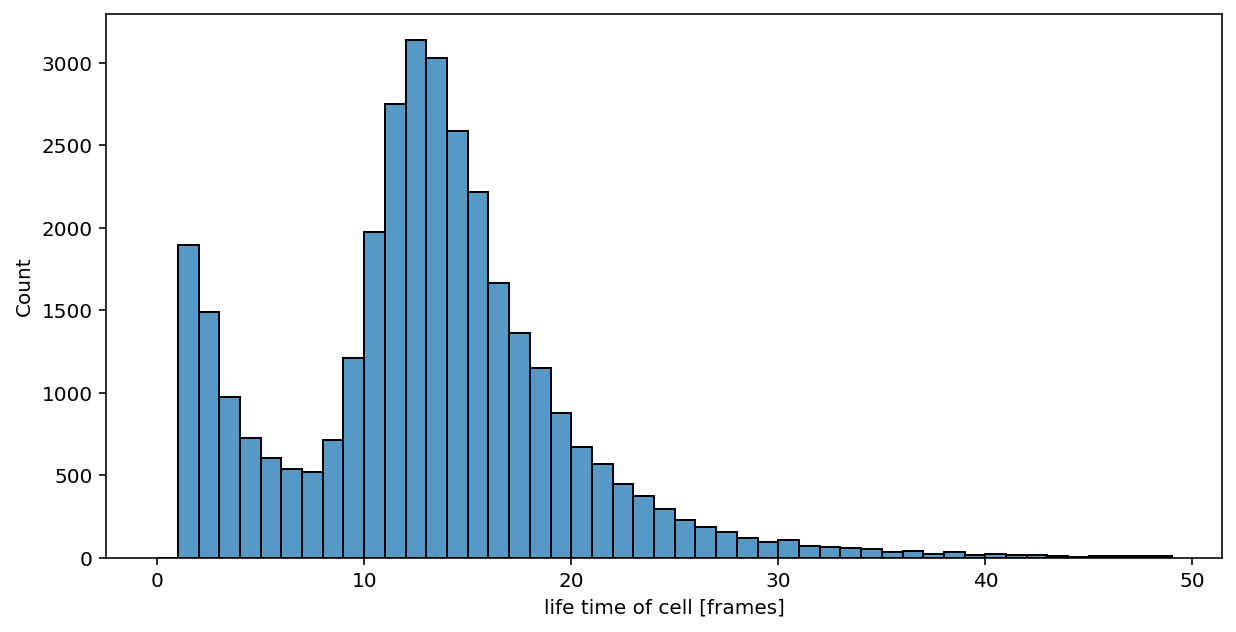

In [5]:
#plot cell life_time for full lineages
has_mom = df["id_par"] > -1
has_d1 = df["id_d1"] > -1
has_d2 = df["id_d2"] > -1
full_lin = has_mom & has_d1 & has_d2

df_compl = df[full_lin].copy()
ax = sns.histplot(data=df_compl.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]');

Next we analyze the change in length between two frames

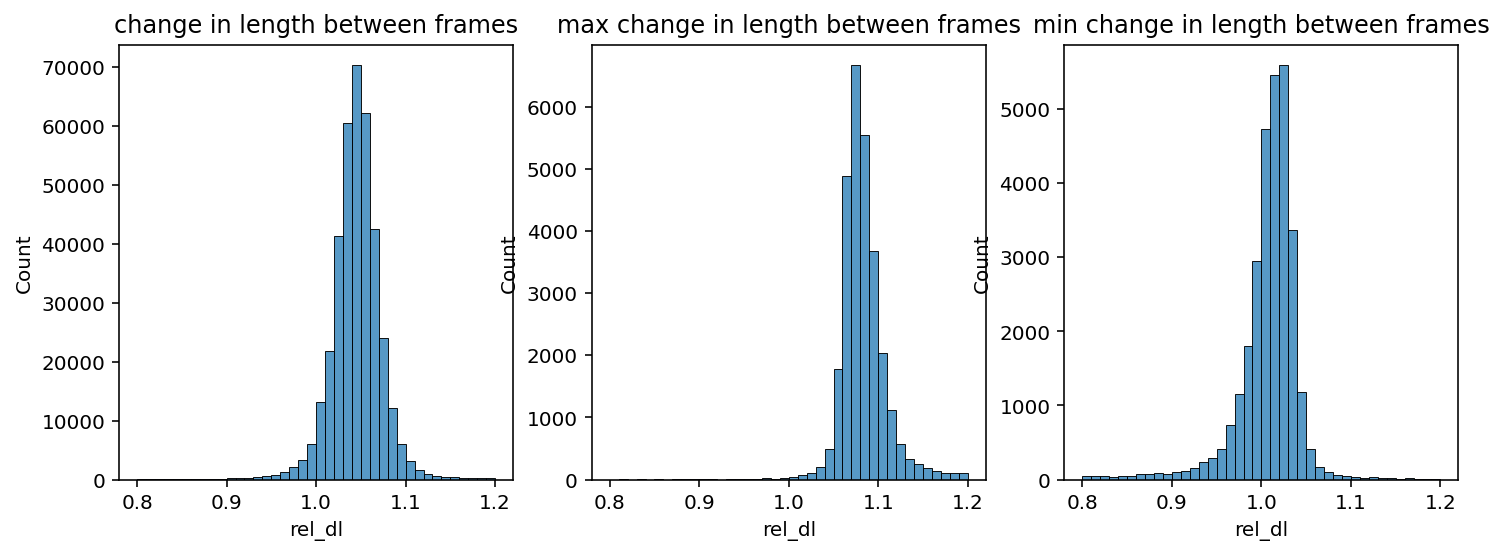

In [6]:
#calc length change
dl = df_compl.groupby('uni_id')['length'].diff()
df_compl['rel_dl'] = (df_compl['length'] + dl)/df_compl['length']
max_dl = df_compl.groupby('uni_id')['rel_dl'].max()
min_dl = df_compl.groupby('uni_id')['rel_dl'].min()

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_compl, x='rel_dl', bins=np.linspace(0.8,1.2,41)).set(title='change in length between frames')
sns.histplot(ax=axs[1], data=max_dl, bins=np.linspace(0.8,1.2,41)).set(title='max change in length between frames')
sns.histplot(ax=axs[2], data=min_dl, bins=np.linspace(0.8,1.2,41)).set(title='min change in length between frames');

Next we analyze the change in length across cell divisions 

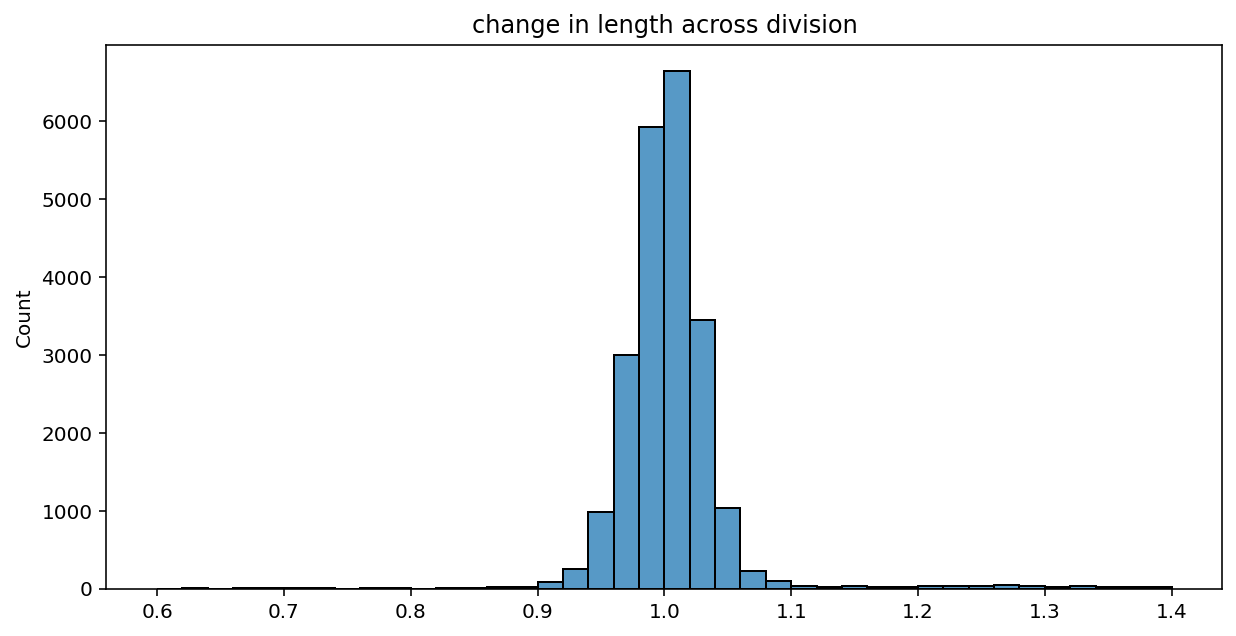

In [7]:
#analyze change in length
dl_list = []
movies_grouped = df_compl.groupby('movie_name')

for name, movie in movies_grouped:
    cells_grouped = movie.groupby('uni_id')
    for name, cell in cells_grouped:
        
        try:
            sis_idx = movie['id_cell'] == cell['id_sib'].iloc[0]
            par_idx = movie['id_cell'] == cell['id_par'].iloc[0]
            
            #get length
            len_cel = cell['length'].iloc[0]
            len_sib = movie.loc[sis_idx, 'length'].iloc[0]
            len_par = movie.loc[par_idx, 'length'].iloc[-1]
        
            dl_list.append((len_cel + len_sib) / len_par)
        except:
            continue
        
sns.histplot(data=dl_list, bins=np.linspace(0.6,1.4,41)).set(title='change in length across division');

---

## Filter data

We filter pairs of cells (siblings) to check for segmentation and tracking mistakes. 

 - We only consider cells whose division is properly tracked (both daughters are identified) and where both offspring cells are tracked for at least `min_num_frm` frames
 - We filter out lineages where length changes too much between division
   - We calculate length change as $\frac{l_{d1}+l_{d2}}{l_p}$
 - We filter out lineages where the length changes too much during life time
    - We calculate length change as $\frac{l(t+\Delta t)}{l(t)} = 2^{\Delta t / t_d}$

These are the filter settings we use:

- `max_dl`: 1.12 ->  max value $l(t+1)/l(t)$ (eq. to td=30min) 
- `min_dl`: 0.92 -> min value $l(t+1)/l(t)$ 
- `max_dl_div`: 1.2 -> max value $l(t+1)/l(t)$ across division  
- `min_dl_div`: 0.94 -> min value $l(t+1)/l(t)$ across division  
- `min_num_frm`: 8 -> min number of frames to track (eq to 40min)
- `cdg_ch`: 'fluo1'  -> cdg channel name

In [8]:
#filter settings
filter_par = {
        'max_dl': 1.12,  
        'min_dl': 0.92,  
        'max_dl_div': 1.2,
        'min_dl_div': 0.94, 
        'min_num_frm': 8,
        'cdg_ch': 'fluo1'}

#columns to copy
cols = ['uni_par_id', 'strain', 'movie_name', 'replicate', 'id_colony', 
        'id_par', 'frames', 'generation', 'age']

#keep track of why lineages are skipped
reason_skipped = { \
        'division not tracked':0,
        'too few frames':0,
        'dL error at div.':0,
        'dL error':0,
        'properly tracked':0}

#init output
df_list = []
#loop movies
movies_grouped = df.groupby('movie_name')
for _, movie in movies_grouped: 
#loop by parent cells
    cells_grouped = movie.groupby('uni_par_id') 
    for _, par_cell in cells_grouped:
        # filter cells    
        new_df = filter_paired_tracks(movie, par_cell, filter_par, reason_skipped)
        if new_df is not None:
                df_list.append(new_df)
                
df_paired = pd.concat(df_list)              

Show reason why lineages were skipped

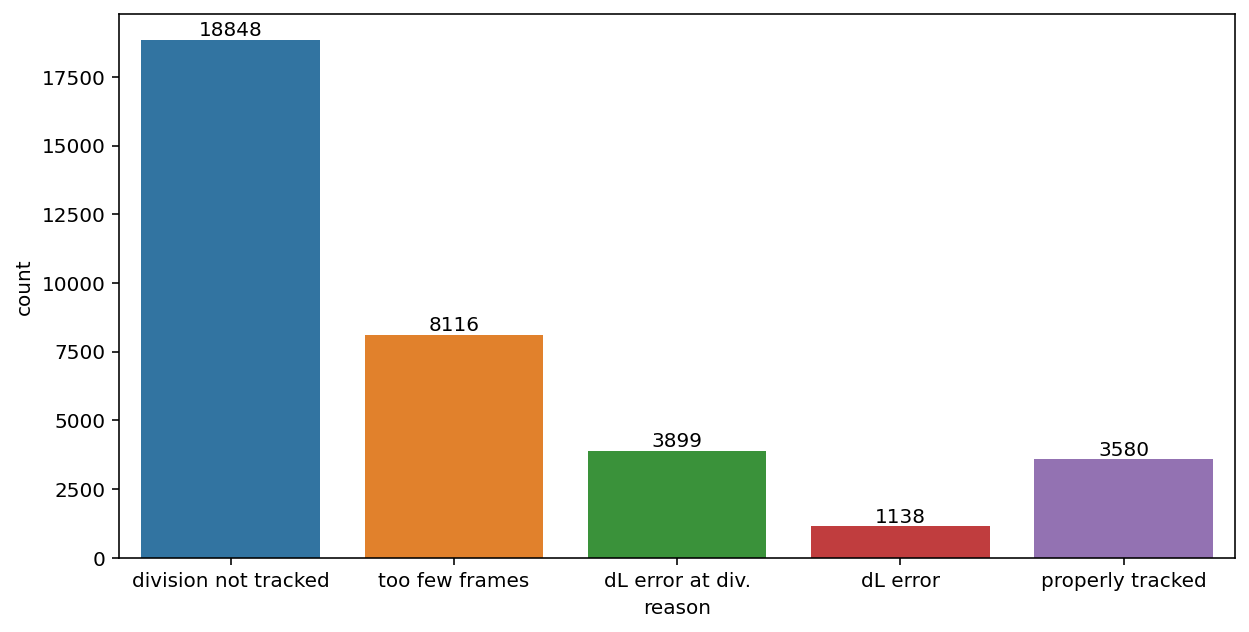

In [9]:
df_stats = pd.DataFrame( [ [k,v] for k,v in reason_skipped.items()],columns=['reason','count'])
ax = sns.barplot(data=df_stats, x='reason', y='count')
ax.bar_label(ax.containers[0]);

---

## Store Data

In [10]:
out_name = save_dir / 'filtered_data_Pa.csv'
df_paired.to_csv(out_name)

---

## Show number of data points per strain

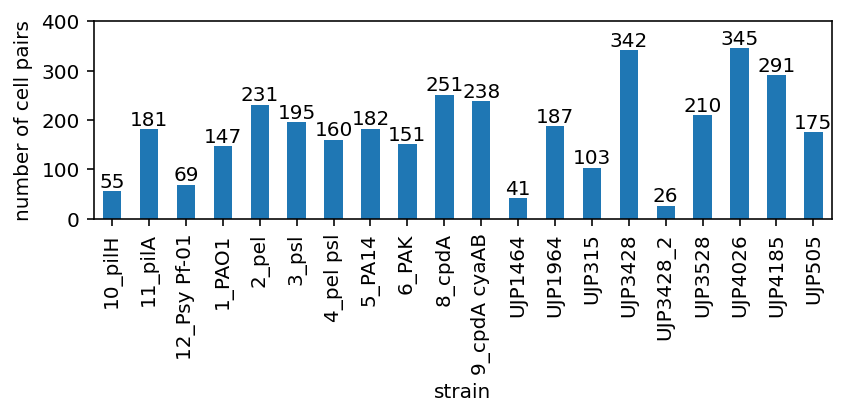

In [11]:
first_frame = df_paired.groupby('uni_par_id').first()

fig,axs = plt.subplots(figsize=(6,3))
num_lin_per_strain = first_frame.groupby('strain').size() 
num_lin_per_strain.head(n=18)
ax = num_lin_per_strain.plot(kind='bar')
ax.bar_label(ax.containers[0]);

ax.set_ylabel('number of cell pairs')
ax.set_ylim((0,400))
fig.tight_layout()

fig.savefig(image_dir / 'number_cell_pairs_per_strain_Pa.pdf')